### 1. Importing libraries and data

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import f_oneway, boxcox, stats

warnings.filterwarnings('ignore')

This data set was downloaded from kaggle. This dataset contains mainly 6 columns and 890 course data. The detailed description:

1. course_title : Contains the course title.
2. course_organization : It tells which organization is conducting the courses.
3. courseCertificatetype : It has details about what are the different certifications available in courses.
4. course_rating : It has the ratings associated with each course.
5. course_difficulty : It tells about how difficult or what is the level of the course.
6. coursestudentsenrolled : It has the number of students that are enrolled in the course.

This section will provide few basic statistics about used data.

The main aim of this project is to look at the different columns and provide some insights on the potential relationships between different columns.


In [185]:
# Load the dataset
df = pd.read_csv('coursea_data.csv')
df.head(5)

,Unnamed: 0,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k
1,743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k
2,874,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k
3,413,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91k
4,635,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320k


### 2. Data cleaning and transformation

One can see that there is a column called "Unnamed", which does not provide any valuable information, therefore, we will drop it.

In [186]:
# Drop the 'Unnamed' column
df = df.drop(['Unnamed: 0'], axis=1)

Let's look at some statistics of the string/text columns.

In [187]:
df.describe(include=['object']).T


,count,unique,top,freq
course_title,891,888,Developing Your Musicianship,2
course_organization,891,154,University of Pennsylvania,59
course_Certificate_type,891,3,COURSE,582
course_difficulty,891,4,Beginner,487
course_students_enrolled,891,205,120k,22


Data consists of 5 columns that contains text/strings and only one column is numerical - course_rating. Column course_students_enrolled is created as a text/string type. Below we are going to convert it to integer type. 

In [188]:
# Convert 'course_students_enrolled' values from string to numeric
def convert_enrollment(enrollment):
    numeric_enrollment = (
        enrollment.replace(r'[km]+$', '', regex=True)
        .astype(float)
        * enrollment.str.extract(r'[\d\.]+([km]+)', expand=False)
        .replace(['k', 'm'], [10**3, 10**6])
        .astype('int64')
    )
    return numeric_enrollment

df['course_students_enrolled'] = convert_enrollment(df['course_students_enrolled'])
df.head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5300.0
1,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17000.0
2,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130000.0
3,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91000.0
4,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320000.0


In [189]:
missing_values = df.isna().sum()
missing_values

course_title                0
course_organization         0
course_Certificate_type     0
course_rating               0
course_difficulty           0
course_students_enrolled    0
dtype: int64

There are no missing values across the columns.

### 3. Exploratory data analysis (EDA)

This part involves exploring each column separately and drawing insights from the data.

In [165]:
# Course with the highest enrollment
max_enrollment = df[df['course_students_enrolled'] == df['course_students_enrolled'].max()]
max_enrollment

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
564,Machine Learning,Stanford University,COURSE,4.9,Mixed,3200000.0


Machine Learning course in Stanford University has the highest amount of enrolled students - 3200000.

Let's take a look at the numerical columns. After transformation we have two numerical columns - 'course_rating' and 'course_students_enrolled'.

In [166]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
course_rating,891.0,4.677329,0.162225,3.3,4.6,4.7,4.8,5.0
course_students_enrolled,891.0,90552.076319,181936.453852,1500.0,17500.0,42000.0,99500.0,3200000.0


We can see that the average course rating is really high with 4.7, knowing the fact that rating is from 0 to 5. To have a better view let's look at the histogram below.

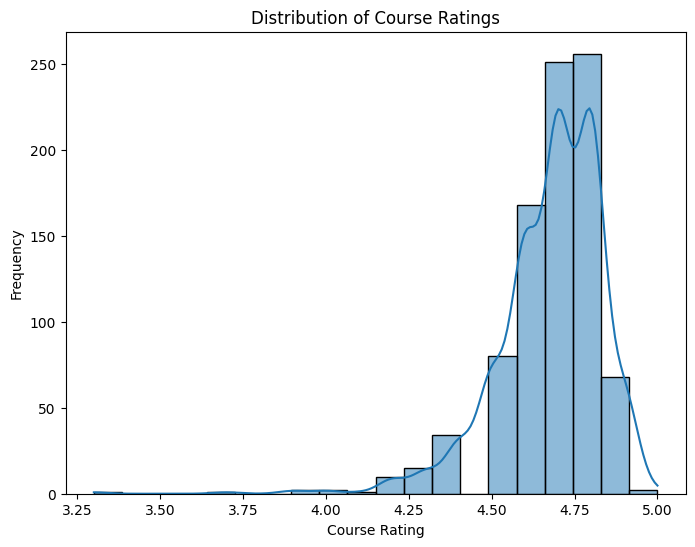

In [190]:
# Histogram to visualize the distribution of course ratings
plt.figure(figsize=(8, 6))
sns.histplot(df['course_rating'], bins=20, kde=True)
plt.title('Distribution of Course Ratings')
plt.xlabel('Course Rating')
plt.ylabel('Frequency')
plt.show()

The histogram is used to understand the distribution of course ratings across the dataset. The histogram reveals a peak around 4.75, indicating that most courses have high ratings.

In [191]:
count_between = ((df['course_rating'] >= 4.5) & (df['course_rating'] <= 5.0)).sum()
total_observations = len(df)
percentage_between = (count_between / total_observations) * 100
print(f"Yes, there are {percentage_between:.2f}% between 4.5 and 5.0")

Yes, there are 92.59% between 4.5 and 5.0


On the other hand course_students_enrolled column has completely different statistics. The minimum value is 1500, whereas, the maximum values is 3200000. Also, standard deviation is significantly higher than the average, which suggests that there is quite big difference between specific courses and enrolled students. Let's look at the boxplot.

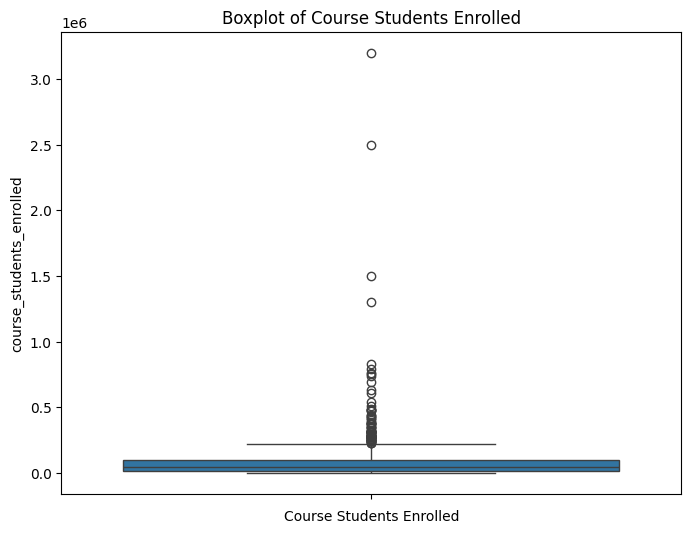

In [169]:
# Boxplot to visualize the spread of course enrollment data
plt.figure(figsize=(8, 6))
sns.boxplot(data=df['course_students_enrolled'])
plt.title('Boxplot of Course Students Enrolled')
plt.xlabel('Course Students Enrolled')
plt.show()

The boxplot shows that there are a few courses that have significantly higher enrollments compared to others.

Let's take a look at the max 10 courses with the highest number of enrolled students.

In [192]:
# Sort the DataFrame by 'course_students_enrolled' column in descending order
df_copy = df.copy()
df_copy=df_copy.drop(['course_title'], axis=1)
df_copy=df_copy.drop(['course_Certificate_type'], axis=1)
df_copy=df_copy.drop(['course_rating'], axis=1)
df_copy=df_copy.drop(['course_difficulty'], axis=1)
sorted_df = df_copy.sort_values(by='course_students_enrolled', ascending=False)

top_ten_enrolled = sorted_df.head(10)
print(top_ten_enrolled)

                  course_organization  course_students_enrolled
564               Stanford University                 3200000.0
815                   Yale University                 2500000.0
688            University of Michigan                 1500000.0
674            University of Michigan                 1300000.0
196          Johns Hopkins University                  830000.0
129  University of California, Irvine                  790000.0
261        University of Pennsylvania                  760000.0
765            University of Michigan                  750000.0
199          Johns Hopkins University                  740000.0
211                   deeplearning.ai                  690000.0


We can conclude that outlier comes from the most popular universities like Stanford and Yale, so we can conclude that these outliers are typing or other errors, but it is normal records. However, we comparing other relationship with other columns we will take into account that this column has some outliers.

Now let's take a look at categorical variables like 'course_Certificate_type' and 'course_difficulty'.

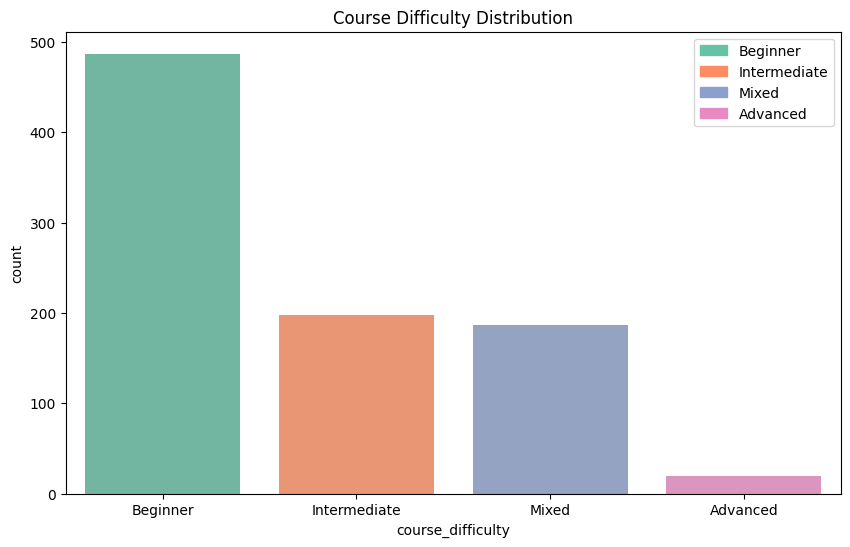

In [173]:
# Count plot to show the distribution of course difficulty levels
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)

# Assigning different colors to each category in 'course_difficulty'
colors = sns.color_palette("Set2")  

# Creating the count plot with specified colors
sns.countplot(x='course_difficulty', data=df, ax=ax, palette=colors)

# Getting the legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
labels = df['course_difficulty'].unique() 

# Adding legend 
ax.legend(handles, labels)

# Adding title to the plot
ax.set_title('Course Difficulty Distribution')

plt.show()

From the plot Course Difficulty Distribution we can see that there are exactly four categories of course difficulty - 'Beginner', 'Intermediate', 'Mixed' and 'Advandced. We can see that the majority of the courses are for begginers indicating a higher availability of entry-level courses. Only few courses is for advanced students. 

Let's take a look at a pie chart if this can give us more information.

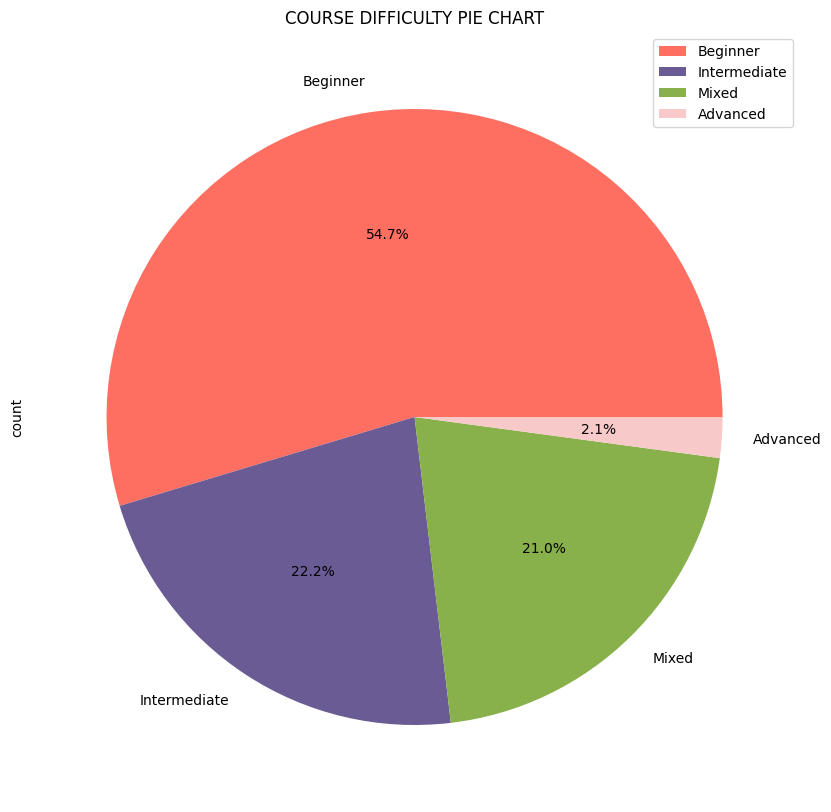

In [174]:
# Custom colors for the pie chart
colors = ["#FF6F61", "#6B5B95", "#88B04B", "#F7CAC9"]   

# Create a pie chart
ax = df['course_difficulty'].value_counts(ascending=False).plot.pie(
    colors=colors,
    autopct=lambda pct: '{:.1f}%'.format(pct) if pct > 0 else '',
    figsize=(15, 10))

plt.title('COURSE DIFFICULTY PIE CHART')

# Adding legend
plt.legend(labels=df['course_difficulty'].value_counts().index, loc="best")

plt.show()

From the Pie chart we can see that more than half of courses are for beginners (55%). The share of courses of intermediate and mixed diffuclty is very similar with 22% and 21% respectively. Whereas, there are only 2% of the total courses for advanced students! From this we could tell that there are quite a lot of courses that targets students that do not have a lot of experience in the subject.

Now let's similary take a look at course certificate type.

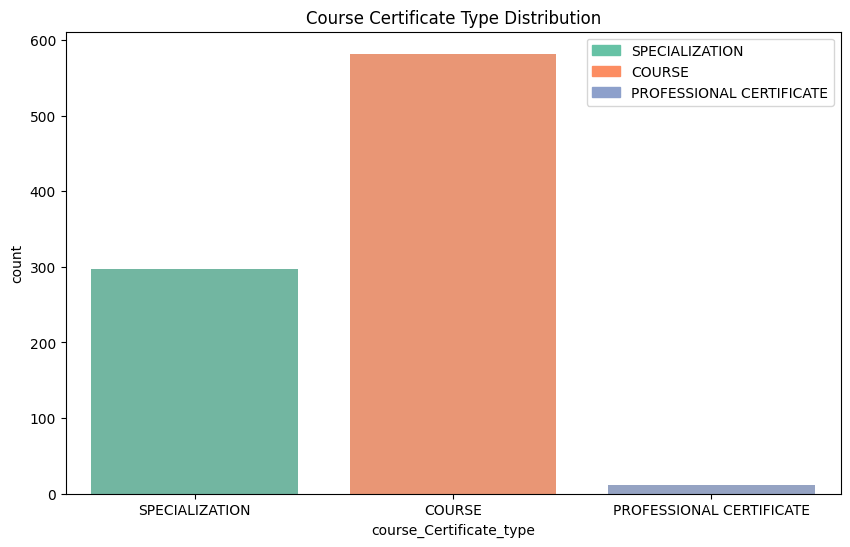

In [175]:
# Count plot to show the distribution of certificate types
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)


colors = sns.color_palette("Set2")  

# Creating the count plot with specified colors
sns.countplot(x='course_Certificate_type', data=df, ax=ax, palette=colors)

# Getting the legend 
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
labels = df['course_Certificate_type'].unique() 

# Adding legend 
ax.legend(handles, labels)

# Adding title to the plot
ax.set_title('Course Certificate Type Distribution')

plt.show()

We can see that there are three types of certificate - 'SPECIALIZATION' , 'COURSE' and 'PROFFESIONAL CERTIFICATE'. Most courses offer 'SPECIALIZATION' or 'COURSE' certificates, with a lower count for 'PROFESSIONAL CERTIFICATE'.

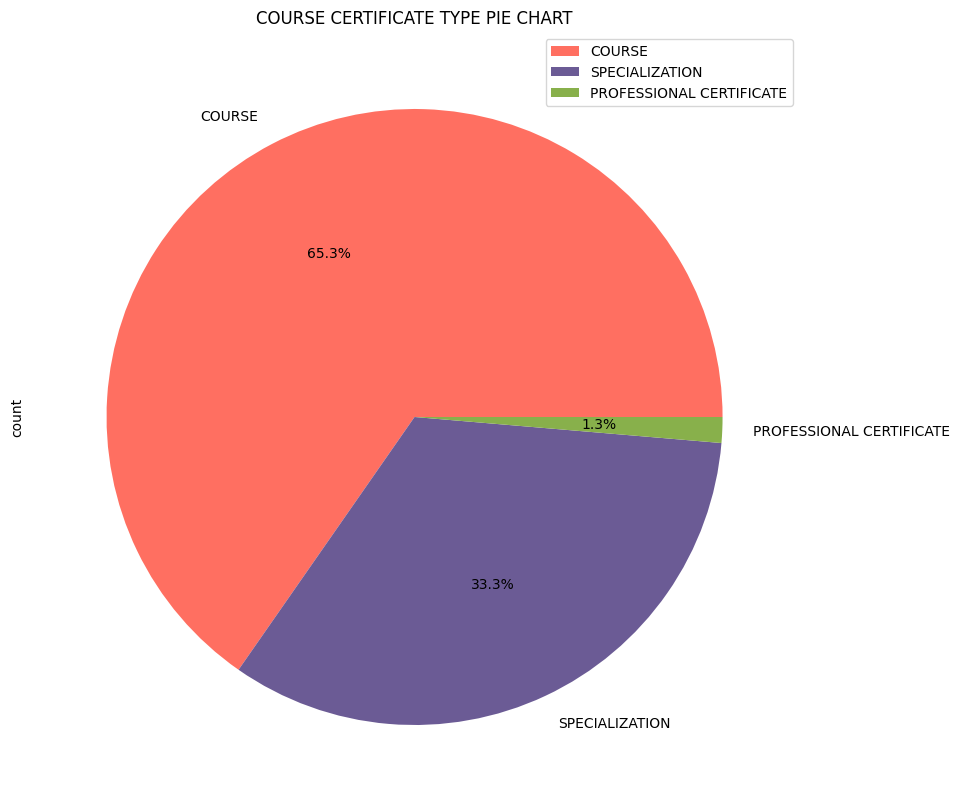

In [148]:
# Custom colors for the pie chart
colors = ["#FF6F61", "#6B5B95", "#88B04B"]  

# Create a pie chart
ax = df['course_Certificate_type'].value_counts(ascending=False).plot.pie(
    colors=colors,
    autopct=lambda pct: '{:.1f}%'.format(pct) if pct > 0 else '',
    figsize=(15, 10))

plt.title('COURSE CERTIFICATE TYPE PIE CHART')

# Adding legend
plt.legend(labels=df['course_Certificate_type'].value_counts().index, loc="best")

plt.show()

The Pie chart shows the same results about what type of certificates you can get. Only 1.3% of the students can get professional certificate.

### 4. Relationship between the variables

In order to get additional numerical variable for correlation matrix we can modify course difficulty column.

Let's assume that if difficulty is beginner then we will assign 0. If Intermediate  - 1, if Mixed - 1.5 and if advanced - 2.

In [177]:
def course_difficulty_modifier(x):
    if x=="Beginner":
        return "0"
    elif x=="Intermediate":
        return "1"
    elif x=="Mixed":
        return "1.5"
    elif x=="Advanced":
        return "2"
    else:
        return "3" 

In [178]:
df['course_difficulty_modified']=df['course_difficulty'].apply(course_difficulty_modifier)
df['course_difficulty_modified']=df['course_difficulty_modified'].apply(pd.to_numeric)
df.head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled,course_difficulty_modified
0,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5300.0,0.0
1,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17000.0,1.0
2,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130000.0,1.5
3,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91000.0,1.5
4,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320000.0,1.5


In [179]:
df['course_difficulty_modified'].describe()

count    891.000000
mean       0.579686
std        0.666487
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        2.000000
Name: course_difficulty_modified, dtype: float64

When looking at the descriptive statistics for course difficulty column we see similar paterns as analysed above.

Now let's compare three numerical columns 'course_rating', 'course_students_enrolled' and 'course_difficulty_modified' and see if there are any correlation between the variables.

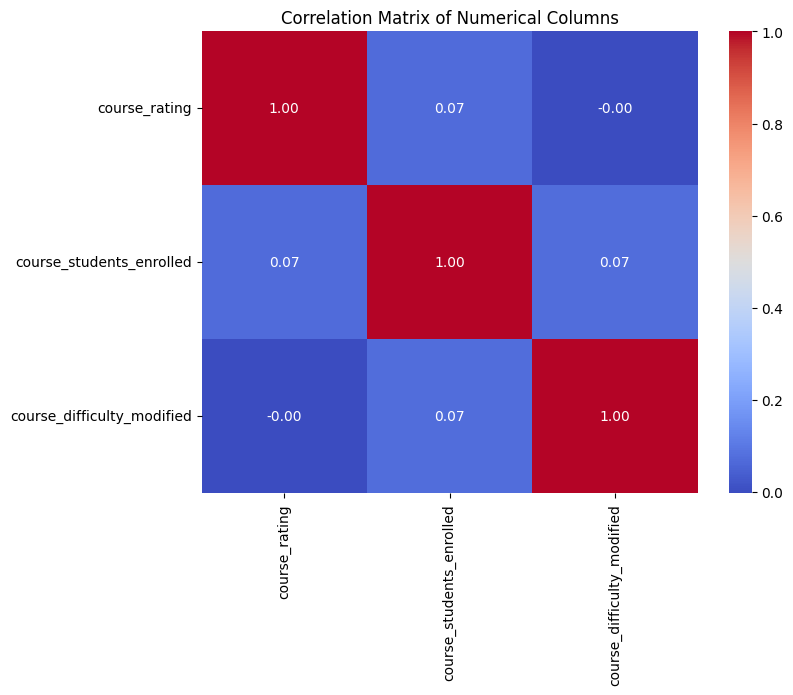

In [180]:
# Calculate and visualize the correlation between numerical columns
numerical_df = df[['course_rating', 'course_students_enrolled', 'course_difficulty_modified']]
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

In [181]:
correlation_matrix

,course_rating,course_students_enrolled,course_difficulty_modified
course_rating,1.000000,0.071090,-0.003017
course_students_enrolled,0.071090,1.000000,0.071804
course_difficulty_modified,-0.003017,0.071804,1.000000


From the correlation matrix one can see that there is a very weak positive correlation (0.071) between 'course_rating' and 'course_students_enrolled'. This indicates a slight tendency that as the course rating increases, there might be a slight increase in the number of students enrolled, but the relationship is not strong.

Almost the same correlation is between 'course_students_enrolled' and 'course_difficulty_modified'. It indicates a slight tendency that as the difficulty of the course increases, there might be a slight increase in the number of students enrolled, but again, the relationship is not strong.

The correlation coefficient of approximately -0.003 between 'course_rating' and 'course_difficulty_modified' indicates an extremely weak negative correlation. This means there is almost no linear relationship between the course rating and the modified difficulty level.

From the correlation matrix we can conclude that there is almost no strong relationship between the three variables.

Previously we have noticed that 'course_students_enrolled' variable has quite few outliers. Let's normalize this column and see if correlation will change.

In [182]:
original_data = df['course_students_enrolled']

# Checking for positive values (Box-Cox transformation requires positive values)
if all(original_data > 0):
    # Box-Cox transformation
    transformed_data, lambda_value = boxcox(original_data)
    
    # Checking normality of transformed data using Shapiro-Wilk test
    normality_test = stats.shapiro(transformed_data)
    
    df['course_students_enrolled_transformed'] = transformed_data
    # Printing lambda value for transformation
    print(f"Lambda value for Box-Cox transformation: {lambda_value}")
    
    # Printing the result of Shapiro-Wilk test for normality
    print(f"Shapiro-Wilk test p-value for transformed data: {normality_test[1]}")
else:
    print("Box-Cox transformation requires positive values")

Lambda value for Box-Cox transformation: 0.012436190477955557
Shapiro-Wilk test p-value for transformed data: 0.26781052350997925


We can see that the lambda value for this column is very small - 0.0124. A lambda value close to 0 suggests a logarithmic transformation, whereas a lambda value close to 1 implies a nearly linear transformation. In this case, a value is very close to 0 indicates a highly skewed transformation.

The Shapiro-Wilk test checks if the variable is normally ditributed after transformation. In this case the p-value of 0.2678 indicates that the transformed data is not significantly different from a normal distribution at a standard significance level of 0.05.

Let's see if correlation will change after transformation.

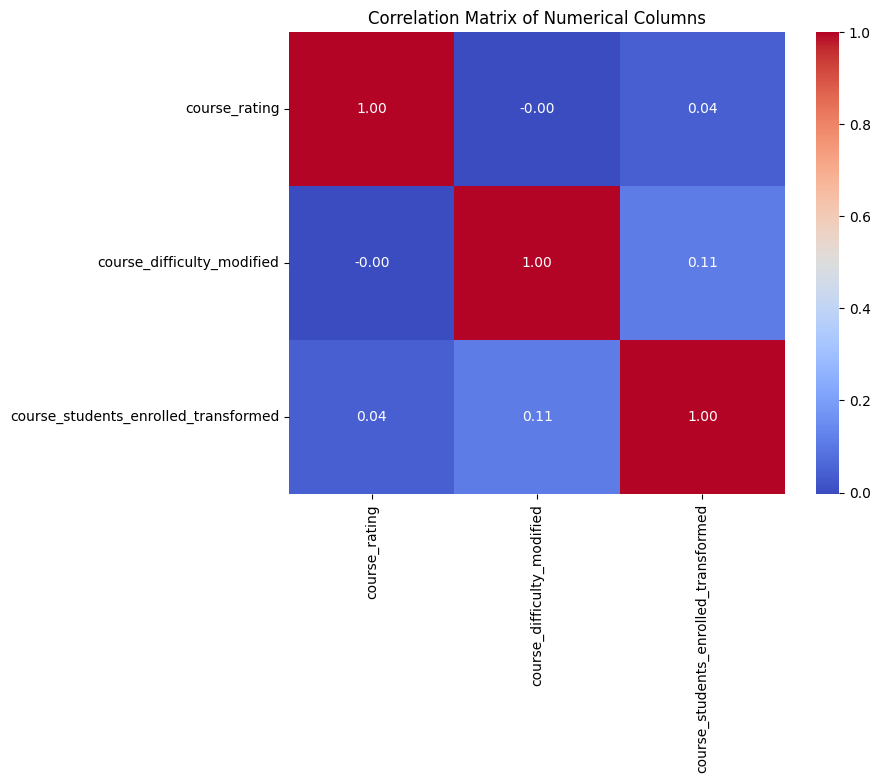

In [154]:
numerical_df = df[['course_rating',  'course_difficulty_modified', 'course_students_enrolled_transformed']]

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

In [155]:
correlation_matrix

,course_rating,course_difficulty_modified,course_students_enrolled_transformed
course_rating,1.000000,-0.003017,0.040600
course_difficulty_modified,-0.003017,1.000000,0.110253
course_students_enrolled_transformed,0.040600,0.110253,1.000000


After transformation there is no significant changes in the correlation matrix.

As the correlation matrix did not show any strong conclusion I will try to apply ANOVA test to see whether the means of a numeric variable differ across categorical groups.

ANOVA test calculates two main statistics - F-statistc and p-value. The F-statistic is compared against critical values from the F-distribution to determine whether there are significant differences in means among the groups. A higher F-statistic implies larger differences among group means relative to within-group variability. The p-value is used to determine the significance of the F-statistic. It indicates the probability of observing an F-statistic as extreme as the one calculated if the null hypothesis (no differences in means among groups) were true. A low p-value suggests strong evidence against the null hypothesis.

In [183]:
# ANOVA test for 'course_difficulty' and 'course_students_enrolled'
difficulty_levels = df['course_difficulty'].unique()

# Select data for each difficulty level
data_by_difficulty = {level: df[df['course_difficulty'] == level]['course_students_enrolled'] for level in difficulty_levels}

# Perform ANOVA test
f_statistic, p_value = f_oneway(*data_by_difficulty.values())

print(f'ANOVA Test - F-statistic: {f_statistic}, p-value: {p_value}')

ANOVA Test - F-statistic: 4.61764947472961, p-value: 0.003260441784982303


The p-value (0.00326) is below the significance level of 0.05, indicating that there are statistically significant differences in the mean 'course_students_enrolled' across the different levels of 'course_difficulty'. This concludes that at least one pair of difficulty levels has significantly different mean student enrollments. However, to identify which specific pairs differ Tukey's HSD test will be performed.

The aim of Tukey's HSD test is to identify specific group differences in means.

In [142]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Tukey's HSD test
tukey_results = pairwise_tukeyhsd(df['course_students_enrolled'], df['course_difficulty'], alpha=0.05)

# Display the summary of the test
print(tukey_results.summary())

            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
   group1       group2     meandiff  p-adj     lower        upper    reject
---------------------------------------------------------------------------
    Advanced     Beginner 15427.5802 0.9834  -93418.9911 124274.1516  False
    Advanced Intermediate   6716.773 0.9987 -105072.7871 118506.3331  False
    Advanced        Mixed 67085.7867 0.4136  -44991.2869 179162.8602  False
    Beginner Intermediate -8710.8073 0.9406  -47941.7718  30520.1573  False
    Beginner        Mixed 51658.2064 0.0052    11615.314  91701.0988   True
Intermediate        Mixed 60369.0137 0.0061   12905.7342 107832.2931   True
---------------------------------------------------------------------------


Above table provides results of the Tukey's HSD test between all possible groups in difficulty level. Reject column indicates whether to reject the null hypothesis (True) or fail to reject (False) based on the p-value (0.05).

Beginner vs. Mixed: The mean difference between 'Beginner' and 'Mixed' groups is statistically significant with a mean difference of approximately 51658.21 and an p-value of 0.0052. Courses categorized as 'Beginner' and 'Mixed' difficulty levels might attract significantly different numbers of students. 'Mixed' difficulty courses tend to enroll a substantially higher number of students compared to 'Beginner' courses. 

Intermediate vs. Mixed: The mean difference between 'Intermediate' and 'Mixed' groups is also statistically significant with a mean difference of around 60369.01 and an p-value of 0.0061. Courses categorized as 'Intermediate' and 'Mixed' difficulty levels also exhibit different student enrollment patterns. 'Mixed' difficulty courses enroll significantly more students compared to 'Intermediate' level courses.

None of the other pairs (Advanced vs. Beginner, Advanced vs. Intermediate, Advanced vs. Mixed, Beginner vs. Intermediate, Advanced vs. Mixed) show statistically significant mean differences as their p-values are higher than the significance level of 0.05 (reject=False).

These reults can imply that courses categorized as 'Mixed' difficulty might be more appealing to a wider audience, possibly offering a balance that suits both beginners and those with some background in the subject.

### 5. Conclusions and suggestions for improvements

This analysis suggests these conclusions:

1. Courses offered by prestigious universities such as Stanford and Yale tend to have significantly higher enrollments, creating outliers in the dataset. These outliers need to be accounted for in further analyses.
2. The majority of courses have high ratings, indicating a trend towards positively rated courses across the platform.
3. A significant portion of courses target beginners, with relatively fewer courses focused on advanced-level difficulty. Mixed difficulty courses tend to enroll more students compared to others.
4. Most courses offer 'Specialization' or 'Course' certificates, while 'Professional Certificate' courses constitute a smaller proportion.
5. There's a very weak positive correlation between course ratings and the number of enrolled students. Additionally, a slight tendency exists for increased enrollments as course difficulty rises, but these correlations are not strong.
6. Statistically significant differences in mean enrollments exist between 'Beginner' vs. 'Mixed' and 'Intermediate' vs. 'Mixed' difficulty level courses. 'Mixed' difficulty courses tend to enroll significantly more students compared to 'Beginner' and 'Intermediate' courses.

Suggestions for improvements:

1. In the future additional variable could be added in order to have more information about different courses.
2. Adapt more advanced modelling in order to understand relationship between variables.
3. Add interactive visualizations.


